#**Implement two hidden layers neural network classifier from scratch in JAX**

In [ ]:
#TODO
# Two hidden layers here means (input - hidden1 - hidden2 - output).
# You must not use flax, optax, or any other library for this task.
# Use MNIST dataset with 80:20 train:test split.
# Manually optimize the number of neurons in hidden layers.
# Use gradient descent from scratch to optimize your network. You should use the Pytree concept of JAX to do this elegantly.
# Plot loss v/s iterations curve with matplotlib.
# Evaluate the model on test data with various classification metrics and briefly discuss their implications.


#**Importing Libraries**

In [249]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax import grad, jit, vmap, pmap, random, value_and_grad
from torchvision.datasets import MNIST
from jax.experimental import optimizers
import matplotlib.pyplot as plt

**Creating necessary variables**

In [261]:
size = [784, 512, 512, 10]
scale = 0.01
num_epochs = 50
batch_size = 128
n_targets = 10

#**Importing Dataset and creating labels**

In [251]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [252]:

def init_MLP(widths, parent_keys):

  params = []
  keys = jax.random.split(parent_keys, len(widths))
  for in_width, out_width, k in zip(widths[:-1], widths[1:], keys):
    weight_key, bias_key = jax.random.split(k)
    params.append(
      [scale*jax.random.normal(weight_key, shape = (out_width, in_width)), 
       scale*jax.random.normal(bias_key, shape = (out_width,))]
    )
  return params


key = jax.random.PRNGKey(0)
MLP_params = init_MLP(size, key)


In [253]:
def predict_MLP(params,x ):
  activation = x
  for w, b in params[:-1]: 
    output = jnp.dot(w, activation) + b
    activation = jax.nn.relu(output)

  w_last, b_last = params[-1]
  logits = jnp.dot(w_last, activation) + b_last

  return logits - logsumexp(logits)




In [254]:
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))

batched_predict = vmap(predict_MLP, in_axes=(None, 0))
batched_preds = batched_predict(MLP_params, random_flattened_images)

#**Grad, Loss, Update FUnction**

In [255]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(MLP_params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - scale * dw, b - scale * db)
          for (w, b), (dw, db) in zip(params, grads)]

In [262]:
import time

log_acc_train, log_acc_test, train_loss = [], [], []
def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

train_acc = accuracy(MLP_params, train_images, train_labels)
test_acc = accuracy(MLP_params, test_images, test_labels)
log_acc_train.append(train_acc)
log_acc_test.append(test_acc)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    MLP_params = update(MLP_params, x, y)
    #train_loss.append(loss)
    train_loss.append(loss)
   

    
  epoch_time = time.time() - start_time
  train_acc = accuracy(MLP_params, train_images, train_labels)
  test_acc = accuracy(MLP_params, test_images, test_labels)
  log_acc_train.append(train_acc)
  log_acc_test.append(test_acc)

  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))
  



Epoch 0 in 20.60 sec
Training set accuracy 0.9821500182151794
Test set accuracy 0.9704999923706055
Epoch 1 in 20.64 sec
Training set accuracy 0.9837166666984558
Test set accuracy 0.9714999794960022
Epoch 2 in 20.63 sec
Training set accuracy 0.9849166870117188
Test set accuracy 0.972000002861023
Epoch 3 in 20.60 sec
Training set accuracy 0.9860166907310486
Test set accuracy 0.9731999635696411
Epoch 4 in 20.60 sec
Training set accuracy 0.9870833158493042
Test set accuracy 0.9739999771118164
Epoch 5 in 10.66 sec
Training set accuracy 0.9879500269889832
Test set accuracy 0.9747999906539917
Epoch 6 in 10.54 sec
Training set accuracy 0.9890666604042053
Test set accuracy 0.9751999974250793
Epoch 7 in 10.88 sec
Training set accuracy 0.9900833368301392
Test set accuracy 0.9752999544143677
Epoch 8 in 10.62 sec
Training set accuracy 0.9908000230789185
Test set accuracy 0.9756999611854553
Epoch 9 in 20.60 sec
Training set accuracy 0.9916000366210938
Test set accuracy 0.9763999581336975
Epoch 10 in

In [263]:
print(train_loss)
print(log_acc_test)

[<function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0x7f7f52e80b00>, <function loss at 0

#**Plotting Graphs**

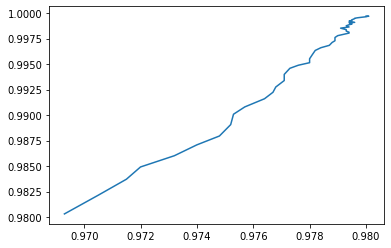

In [264]:
plt.plot(jnp.array(log_acc_test), jnp.array(log_acc_train))
plt.show()

In [265]:
mnist_img_size = (28, 28)

#**Searching for dead neurons**
**Manual optimization for the neurons**

In [260]:


def fetch_activations2(params, x):
    hidden_layers = params[:-1]
    collector = []

    activation = x
    for w, b in hidden_layers:
        output = jnp.dot(w, activation) + b
        activation = jax.nn.relu(output)
        collector.append(activation)

    return collector

batched_fetch_activations2 = vmap(fetch_activations2, in_axes=(None, 0))

imgs = next(iter(test_images))
lbls = next(iter(test_labels))

size1 = [784, 512, 256, 10]
MLP_params2 = init_MLP(size1, key)

batch_activations = batched_fetch_activations2(MLP_params2, imgs)
print(batch_activations[1].shape)  # (128, 512/256)

dead_neurons = [np.ones(act.shape[1:]) for act in batch_activations]

for layer_id, activations in enumerate(batch_activations):
    dead_neurons[layer_id] = np.logical_and(dead_neurons[layer_id], (activations == 0).all(axis=0))

for layers in dead_neurons:
    print(np.sum(layers))

ValueError: ignored